Copyright (c) Owkin, Inc.

In [ ]:
# Copyright (c) Owkin, Inc.
# All rights reserved.
#
# This source code is licensed under the licence available at
# https://github.com/owkin/HistoSSLscaling/blob/main/LICENSE.txt

# Copyright (c) Owkin, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

# Phikon

### Scaling Self-supervised Learning for Histopathology with Masked Image Modeling

This notebook is supported by the [Hugging Face blog post](https://huggingface.co/blog/EazyAl/phikon)

For detailed information about the model you can view the scientific publication on [MedRxiv](https://www.medrxiv.org/content/10.1101/2023.07.21.23292757v2).

Requirements to run this notebook on Collab: 1 Tesla T4 GPU with 15 Gb RAM.



### Install requirements


In [ ]:
!pip install accelerate datasets evaluate transformers peft scikit-learn torch torchvision evaluate --quiet

### Connect to google drive (optional)

We advise you to mount your Google Drive so that to store the different datasets and models permanently. Otherwise, you will need to download them again if the session crashes.

```python
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')

# Set your working directory and cache directory which
# will contain datasets and models
working_directory = Path("/content/drive/your_working_dir")
cache_dir = working_directory / "cache"
```

In [ ]:
# default: we set the working directory to the temporary directory
# created by Colab

from pathlib import Path
working_directory = Path(".").resolve()
cache_dir = working_directory / "cache"

# Camelyon16 features

In the following example, we show how the features extracted from the model can be used for a classification task with a smaller model.

The [Camelyon 16](https://camelyon16.grand-challenge.org/) dataset was created to automatically predict the presence of metastases in hematoxylin and eosin (H&E) stained whole-slide images (WSI) of lymph node sections. Due to the very high resolution of WSIs (up to 100,000 x 100,000 pixels), the standard approach here is to create small patches from each WSI, compute features out of those patches using Phikon (kept frozen) and finally aggregate them, at the slide-level, to predict the presence of metastatis for the patient. In this example, we sampled 1,000 tiles per WSI, later yielding a matrix of 1,000 features. Original patches were extracted at 0.5 $\mu$m/pixel with shape 224x224 pixels. The training and testing [datasets](https://camelyon16.grand-challenge.org/Data/) consist of 269 and 130 WSIs, respectively.

We start by preparing the data.


In [ ]:
import sys
from pathlib import Path

from huggingface_hub import hf_hub_download

# We first download custom scripts from Hugging Face
for script in ["data", "module", "trainer", "utils"]:
    data_file = hf_hub_download(
        repo_id="owkin/camelyon16-features",
        filename=f"scripts/{script}.py",
        repo_type="dataset",
        cache_dir=cache_dir
    )

  # The data script handles data loading
  # Module loads the Chowder model to make predictions (described after)
  # Trainer is responsible for updating the model based on data batches
  # Utils is a set of utility functions

# Using sys.path.append, we enable the import of functions inside
# the python scripts we just downloaded
scripts_dir = Path(data_file).parent
sys.path.append(str(scripts_dir))

In [ ]:
import numpy as np

from data import SlideFeaturesDataset

# ``SlideFeaturesDataset`` is used to first download the data from
# Hugging Face, then create a proper torch dataset inherited
# from ``torch.utils.data.Dataset` class. The ``__getitem__```
# function of this dataset returns (X, y). X is a matrix
# of features for the slide with dimension (1000, 768). 1000
# corresponds to the number of features (i.e. number of tiles)
# sampled from the given slide, while 768 is the dimension of
# the features (i.e. the output dimension of Phikon).
# y is the label (0 or 1 for absence or presence of metastasis).

# ``cam16_design_dataset`` contains 269 WSIs
cam16_design_dataset = SlideFeaturesDataset(
    "owkin/camelyon16-features",
    split="Phikon_train",
    cache_dir=cache_dir
)

# ``cam16_test_dataset`` contains 130 WSIs
cam16_test_dataset = SlideFeaturesDataset(
    "owkin/camelyon16-features",
    split="Phikon_test",
    cache_dir=cache_dir
)

# We store the indices and labels of the whole training dataset
# for cross-validation
cam16_design_indices = np.arange(len(cam16_design_dataset))
cam16_design_labels = cam16_design_dataset.labels

We then use the Chowder model for classification. For more information on the Chowder model you can view the publication [here](https://arxiv.org/abs/1802.02212). Chowder is a small and interpretable Multiple Instance Learning model designed by Owkin. For a given slide with $n_{tiles}$ tiles, Phikon is kept *frozen* to generate a matrix of features of size $(n_{tiles}, 768)$. In this example, $n_{tiles}=1000$. From this matrix of "local descriptors", Chowder learns a weighted average of the 768$^1$ components of Phikon (framed under a 1D convolution) to output $N$ scores. Top positive and negative scores are then selected through a max-min layer; and only those are passed to a standard MLP to finally predict the slide label (overall presence or absence of metastasis). Chowder is trained on Phikon features from Camelyon-16 training dataset.


$^1$: Note that the figure mentions 2048 for the dimension of local descriptors. Originally, Chowder was first applied on MoCo features (``MoCo[RN50w2]COAD``in our publication). Here, 2048 is replaced by 768 as the output dimension of Phikon is 768 (ViT-B transformer).









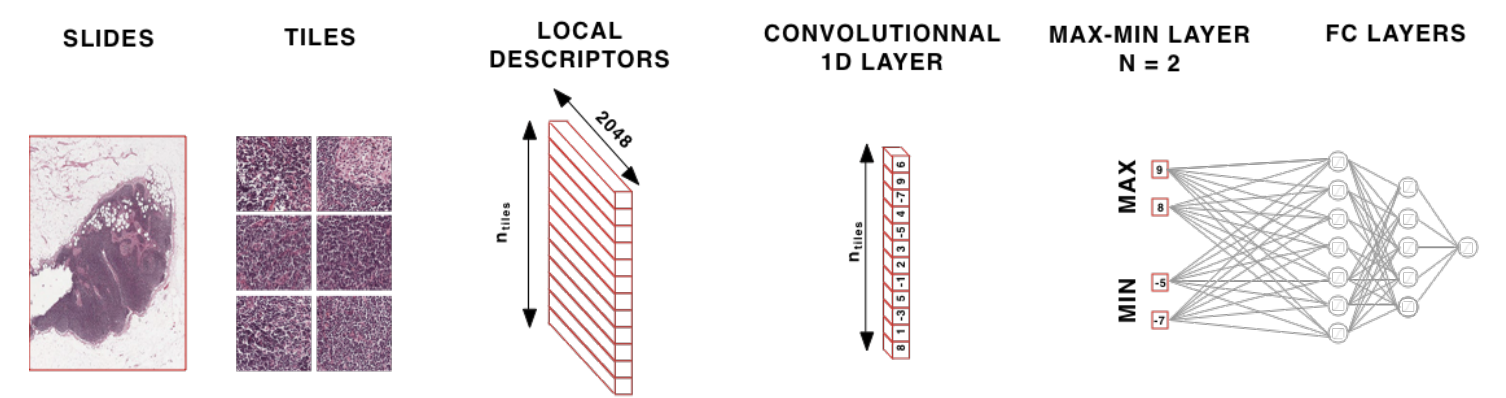



In [ ]:
import torch

from module import Chowder

chowder = Chowder(
    in_features=768,                     # output dimension of Phikon
    out_features=1,                      # dimension of predictions (a probability for class "1")
    n_top=5,                             # number of top scores in Chowder (in the image, N is 2)
    n_bottom=5,                          # number of bottom scores in Chowder
    mlp_hidden=[200, 100],               # MLP hidden layers after the max-min layer
    mlp_activation=torch.nn.Sigmoid(),   # MLP activation
    bias=True                            # bias for first 1D convolution which computes scores
)

def print_trainable_parameters(model: torch.nn) -> None:
    """Print number of trainable parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param}"
        f" || trainable%: {100 * trainable_params / all_param:.2f}"
    )

# Chowder has 23,170 parameters: it's a very small model !
print_trainable_parameters(chowder)

In [ ]:
from utils import auc, pad_collate_fn

# We define the loss function, optimizer and metrics for the training
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam              # Adam optimizer
metrics = {"auc": auc}                    # AUC will be the tracking metric

# ``collator`` is a function that apply a deterministic
# transformation to a batch of samples before being processed
# by the GPU. Here, this function is ``pad_collate_fn``. The
# goal of this function is align matrices of features (the inputs)
# in terms of shape. Indeed, some WSI may have 200 features (very
# small piece of tissues) or 1,000 (the maximum we set). In that case,
# all matrices will have a shape of at most the bigger matrices in the
# batch. Our (200, 768) input matrix will become a (1000, 768) matrix
# with 800 ``inf`` values. A boolean mask is stored so that to tell
# torch not to process these 800 values but only focus on the 200 real ones

collator = pad_collate_fn

In [ ]:
import warnings
from copy import deepcopy
import multiprocessing
from datetime import datetime

from IPython.display import clear_output

from sklearn.model_selection import StratifiedKFold
from trainer import TorchTrainer, slide_level_train_step, slide_level_val_step

# We run a 5-fold cross-validation with 1 repeat (you can tweak these parameters)
n_repeats = 1
n_folds = 5
train_metrics, val_metrics = [], []
test_logits = []

cv_start_time = datetime.now()

for repeat in range(n_repeats):
    print(f"Running cross-validation #{repeat+1}")
    # We stratify with respect to the training labels
    cv_skfold = StratifiedKFold(
        n_splits=n_folds,
        shuffle=True,
        random_state=repeat,
    )
    cv_splits = cv_skfold.split(cam16_design_indices, y=cam16_design_labels)

    # 1 training fold approximately takes 25 seconds
    for i, (train_indices, val_indices) in enumerate(cv_splits):
        fold_start_time = datetime.now()
        trainer = TorchTrainer(
            model=deepcopy(chowder),
            criterion=criterion,
            metrics=metrics,
            batch_size=16,                           # you can tweak this
            num_epochs=15,                           # you can tweak this
            learning_rate=1e-3,                      # you can tweak this
            weight_decay=0.0,                        # you can tweak this
            device="cuda:0",
            num_workers=multiprocessing.cpu_count(), # you can tweak this
            optimizer=deepcopy(optimizer),
            train_step=slide_level_train_step,
            val_step=slide_level_val_step,
            collator=pad_collate_fn,
        )

        print(f"Running cross-validation on split #{i+1}")
        cam16_train_dataset = torch.utils.data.Subset(
            cam16_design_dataset, indices=train_indices
        )
        cam16_val_dataset = torch.utils.data.Subset(
            cam16_design_dataset, indices=val_indices
        )

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            # Training step for the given number of epochs
            local_train_metrics, local_val_metrics = trainer.train(
                cam16_train_dataset, cam16_val_dataset
            )
            # Predictions on test (logits, sigmoid(logits) = probability)
            local_test_logits = trainer.predict(cam16_test_dataset)[1]

        train_metrics.append(local_train_metrics)
        val_metrics.append(local_val_metrics)
        test_logits.append(local_test_logits)
        fold_end_time = datetime.now()
        fold_running_time = fold_end_time - fold_start_time
        print("\n-----------------------------Finished in {}---------------------------------------\n".format(fold_running_time))
    clear_output()
cv_end_time = datetime.now()
cv_running_time = cv_end_time - cv_start_time
print("\nFinished cross-validation in {}".format(cv_running_time))

After training is finished, we use the metrics we loaded in utils to see how the model performs. Cross-validation results are averaged across the folds (hence the standard deviation). Model fitted on the different CV folds (5 in the example) are used to create an ensembling model: predictions on the test set are averaged across the 5 models.

In [ ]:
from utils import get_cv_metrics, roc_auc_score

cv_train_metrics = get_cv_metrics(train_metrics)
cv_val_metrics = get_cv_metrics(val_metrics)
test_metrics = trainer.evaluate(cam16_test_dataset)

print("Cross-validation results:")
for k, v in cv_train_metrics.items():
    print(f"mean_train_{k}: {v}")

for k, v in cv_val_metrics.items():
    print(f"mean_val_{k}: {v}")

print("\nEnsembling results on test set:")
test_auc = roc_auc_score(
    cam16_test_dataset.labels,
    np.mean(test_logits, axis=0)
)
print(f"test_auc: {test_auc:.4f}")

# Fine-tuning Phikon using LoRA

The real power of Phikon lies in its ability to improve performance when fine-tuned on previously unseen datasets so that the model specializes on a cancer subtype.

Here we show an example of how you can fine-tune the model on your own dataset using the Hugging Face transformers and peft library. For the example we use the [NCT-CRC](https://zenodo.org/records/1214456) dataset (Macenko-normalized version), which is a dataset of colorectal cancer slides. The goal of NCT-CRC dataset is to classify colorectal cancer (and normal) tissues into 9 categories, from normal tissue to adenocarcinoma. The original training and testing datasets are composed of 100,000 and 7,180 images, respectively. We consider here a subset of 500 images for the training dataset set to further highlight the efficiency of Phikon in very low data regime (0.5%).

Begin by preparing the dataset.




In [ ]:
import os
from typing import Optional
import random

from datasets import load_dataset
from transformers import set_seed as set_seed_hf
from transformers import AutoImageProcessor

dataset_name = "owkin/nct-crc-he"
# You can change the dataset name above if you wish to finetune the model on your own dataset.


# We set a seed globally for data loading and training
SEED = 123

def set_seed(seed: Optional[int] = None):
    """Set all seeds to make results reproducible (deterministic mode).
    When seed is None, disables deterministic mode.
    Credits @BramVanroy
    """
    if seed is not None:
        set_seed_hf(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

dataset = load_dataset(
    dataset_name,
    split="nct_crc_he_1k",
    cache_dir=cache_dir
)
# From the NCT-CRC 999 samples, we create train and validation sets
# of 500 and 499 images, respectively
dataset_splits = dataset.train_test_split(
    test_size=(499 / 999),
    shuffle=True,
    seed=SEED
)
train_dataset = dataset_splits["train"]
val_dataset = dataset_splits["test"]

# Test dataset contains 7,180 images
test_dataset = load_dataset(
    dataset_name,
    split="crc_val_he_7k",
    cache_dir=cache_dir
)
print(
    f"Training dataset size: {len(train_dataset)}\n"
    f"Validation dataset size: {len(val_dataset)}\n"
    f"Test dataset size: {len(test_dataset)}\n"
)

Download the model using Hugging Face transformers.

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("owkin/phikon")
print(image_processor)

Preprocessing code to normalize and resize the images.

In [ ]:
from typing import Any
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

# ImageNet normalization
normalize = Normalize(
    mean=image_processor.image_mean,
    std=image_processor.image_std
)

# train transforms = random crop, resizing to 224x224, random flip, normalization
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

# val transforms = resizing to 224x224, normalization
val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch: dict[str, Any]) -> dict[str, Any]:
    """Apply ``train_transforms`` across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image) for image in example_batch["image"]
    ]
    return example_batch


def preprocess_val(example_batch: dict[str, Any]) -> dict[str, Any]:
    """Apply ``val_transforms`` across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image) for image in example_batch["image"]
    ]
    return example_batch

# Apply the transformations
train_dataset.set_transform(preprocess_train)
val_dataset.set_transform(preprocess_val)
test_dataset.set_transform(preprocess_val)

The labels for the dataset below, **you  need to change these if fine-tuning on a different dataset**.

In [ ]:
from transformers import AutoModelForImageClassification

# Labels from our dataset
label2id = {
    '0': "ADI",
    '1': "BACK",
    '2': "DEB",
    '3': "LYM",
    '4': "MUC",
    '5': "MUS",
    '6': "NORM",
    '7': "STR",
    '8': "TUM"
}
id2label = {v: k for (k, v) in label2id.items()}

# Load the model
model = AutoModelForImageClassification.from_pretrained(
    "owkin/phikon",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=False,
    cache_dir=cache_dir,
)
print_trainable_parameters(model)

We also create a version of Phikon where the model is kept frozen and only the classifier head is trained (0.01% of the training parameters).

In [ ]:
from copy import deepcopy

frozen_model = deepcopy(model)

for name, param in frozen_model.named_parameters():
     if not name.startswith("classifier."):
        param.requires_grad = False
print_trainable_parameters(frozen_model)

LoRA fine-tuning only requires 0.70% of the original trainable parameters!

In [ ]:
from peft import LoraConfig, get_peft_model


# load and configure LoRA from Hugging Face peft library
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

Training configuration.

In [ ]:
import numpy as np
import torch

import evaluate
from transformers import TrainingArguments, Trainer

# LoRA configuration

batch_size = 128
args = TrainingArguments(
    "phikon-finetuned-nct-1k",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    gradient_accumulation_steps=1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    seed=SEED,
    num_train_epochs=10,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # dataset is roughly balanced
    push_to_hub=False,
    label_names=["labels"],
)

# Metric configuration

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred: np.ndarray) -> float:
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Inputs generation for training

def collate_fn(examples) -> dict[str, torch.Tensor]:
    """Create the inputs for LoRA from an example in the dataset."""
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Here is the final trainer
trainer_lora = Trainer(
    model=lora_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Run the training below:

In [ ]:
import warnings

from transformers.utils import logging


# We display the accuracy on the test set at the end
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    train_results_lora = trainer_lora.train()
    metrics_lora = trainer_lora.evaluate(test_dataset)
    trainer_lora.log_metrics("Fine-tuned model: VAL-CRC-7K", metrics_lora)

We now do the same training thing fully-frozen Phikon.

We observe up to a +2 increase in multi-class accuracy using LoRA fine-tuning, for only 30 seconds of extra training cost.

In [ ]:
trainer_frozen = Trainer(
    frozen_model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    train_results_frozen = trainer_frozen.train()
    metrics_frozen = trainer_frozen.evaluate(test_dataset)
    trainer_frozen.log_metrics("Frozen model: VAL-CRC-7K", metrics_frozen)

## Visualizing features

We can then visualize the features. We do this for a frozen model as well as LoRA in order to examine the differences in the embeddings.

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd

from matplotlib.axes._axes import Axes
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

# First we define a set of functions to
# 1) get the embeddings from the models
# 2) compute the 2D projections using the t-SNE algorithm
# 3) visualize these projections using ``seaborn```

def get_raw_embeddings(model, dataset, use_fp16: bool = True):
    """Retrieve tiles embeddings from a model equipped with a classifier head."""
    embeddings = []
    for pixel_values in tqdm(dataset["pixel_values"]):
        image = pixel_values.unsqueeze(0).to(
            "cuda:0" if torch.cuda.is_available() else "cpu",
            torch.float16 if use_fp16 else torch.float32
          )
        output = model(image, output_hidden_states=True)
        _embeddings = output.hidden_states[-1][:, 0, :].detach().cpu().numpy()
        embeddings.append(_embeddings)
    return np.concatenate(embeddings, axis=0)


def get_tsne_embeddings(raw_embeddings: np.ndarray, **kwargs):
    """Compute 2-dimensional tsne projections from raw embeddings."""
    tsne = TSNE(**kwargs)
    tsne_embeddings = tsne.fit_transform(raw_embeddings)
    tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["tsne-1", "tsne-2"])
    tsne_embeddings["Tissue type"] = test_subset_labels
    tsne_embeddings["Tissue type"] = tsne_embeddings["Tissue type"].astype(str).replace(label2id)
    return tsne_embeddings

def plot_tsne_embeddings(tsne_embeddings: np.ndarray, title: str, ax: Axes):
    """Plot tsne embeddings in the 2D space."""
    sns.scatterplot(
        x="tsne-1", y="tsne-2",
        hue="Tissue type",
        palette=sns.color_palette("hls", 9),
        data=tsne_embeddings,
        legend="full",
        alpha=0.3,
        ax=ax
    )
    ax.set_title(title)
    return ax

We consider a subset of 1,000 images from the original test set.

In [ ]:
subset_size = 1000
test_subset = test_dataset[:subset_size]

print(f"Computing LORA and frozen models embeddings on {subset_size} test images...")
test_subset_embeddings_lora = get_raw_embeddings(
    model=lora_model, dataset=test_subset
)
test_subset_embeddings_frozen = get_raw_embeddings(
    model=frozen_model, dataset=test_subset
)
test_subset_labels = np.array(test_subset["label"])

print("Computing tsne projections...")
tsne_embeddings_lora = get_tsne_embeddings(
    test_subset_embeddings_lora, n_components=2
)
tsne_embeddings_frozen = get_tsne_embeddings(
    test_subset_embeddings_frozen, n_components=2
  )

The differences between the LoRA fine-tuned and frozen models are small due to the highly separable nature of NCT-CRC prediction task (different tissues can be distinguished easily by the naked eye). However, we notice that LoRA fine-tuning allows to better disentangle clusters such as Lymphocytes (Yellow) and Tumor (red), which can play a significant role in cancer diagnosis.

In [ ]:
print("Plotting in 2 dimensions.")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0] = plot_tsne_embeddings(
    tsne_embeddings_lora, title="Lora embeddings", ax=axes[0]
)
axes[1] = plot_tsne_embeddings(
    tsne_embeddings_frozen, title="Frozen embeddings", ax=axes[1]
)
plt.show()